# Stationary

This notebook aims to make the target variable stationary

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as st

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.seasonal import seasonal_decompose


plt.style.use("seaborn-v0_8-muted")

In [4]:
# Read the necessary data
passengers = pd.read_csv("data/dataframe.csv")

# Create column with all passengers
passengers = passengers.set_index("datetime").drop(columns = "Unnamed: 0")
passengers["total"] = passengers.sum(axis = 1)
passengers.index = pd.to_datetime(passengers.index, format = "ISO8601")

In [121]:

# Helpful functions for showing results of analysis

# Show summary statistics for different time frames
def split_series(series):
    X = series.values
    split1, split2 = round(len(X) / 3), round(len(X) / 3)*2
    X1, X2, X3 = X[0:split1], X[split1:split2], X[split2:]
    mean1, mean2, mean3 = X1.mean(), X2.mean(), X3.mean()
    std1, std2, std3 = X1.std(), X2.std(), X3.std()
    print(f"The means are{mean1: 0.2f},{mean2: 0.2f} and{mean3: 0.2f}")
    print(f"The stds are{std1: 0.2f},{std2: 0.2f} and{std3: 0.2f}")

# Run KPSS test (Null hypothesis: x is level or trend stationary)
def kpss_test(series):
    print("Results of KPSS Test:")
    kpsstest = kpss(series, regression="ct", nlags="auto")
    print(f"Test Statistic {kpsstest[0]:0.3f}")
    print(f"p-value: {kpsstest[1]: 0.4f}")
    print(f"Lags used: {kpsstest[2]: 0.0f}")


# Run a Augmented Dickey-Fuller test (Null hypothesis: time series contains a unit root and is non-stationary)
def run_test(series):
    result=adfuller (series, autolag="AIC", regression = "ctt")
    print(f"Results of the AD Fuller test:")
    print(f"Test Statistic: {result[0]: 0.3f}")
    print(f"p-value: {result[1]: 0.4f}")
    
# Plot results
def plot_three(series, title, window_size = 24*7):
    figs = plt.figure(figsize=(10, 6))
    fig, axs = plt.subplots(2,1, figsize=(10,6))
    
    # Set a title
    figs.suptitle(title, fontweight = "bold", fontsize = 16)
    
    gs = figs.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
    
    # Create the Axes for subplots.
    ax = figs.add_subplot(gs[1, 0])
    ax.tick_params(axis='x', which='major')
    ax_histx = figs.add_subplot(gs[0, 0], )
    ax_histy = figs.add_subplot(gs[1, 1])

    
    # Format x axis
    date_form = DateFormatter("%b-%Y")
    ax.xaxis.set_major_formatter(date_form)
    
    # Populate the Axes.
    ax.plot(series, alpha = 0.8)
    ax.set_xlabel("Passengers")
    ax_histx.hist(series, alpha=0.5, edgecolor = "black", color = "pink")
    # Add moving average 
    rolling = series.rolling(window=window_size).mean()
    ax_histy.hist(rolling, alpha=0.5, orientation="horizontal", edgecolor = "black", color = "pink")
    ax_histy.set_yticklabels([])
    ax_histx.set_xticklabels([])
    ax_histx.set_title(Distribution of passenger counts')
    ax_histy.set_title(f'Rolling means', rotation=0)
    
    # Plot series and Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
    st.graphics.tsa.plot_pacf(series, ax = axs[0], lags = 24)
    st.graphics.tsa.plot_acf(series, axs[1], lags = 24)
    plt.tight_layout()
    # Run the tests
    run_test(series)
    print("----------------")
    kpss_test(series)
    print("----------------")
    split_series(series)

Results of the AD Fuller test:
Test Statistic: -14.877
p-value:  0.0000
----------------
Results of KPSS Test:
Test Statistic 0.091
p-value:  0.1000
Lags used:  43
----------------
The means are 3361.70, 3641.41 and 3754.81
The stds are 3379.47, 3605.95 and 3778.90


/tmp/ipykernel_1267/13139041.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(series, regression="ct", nlags="auto")


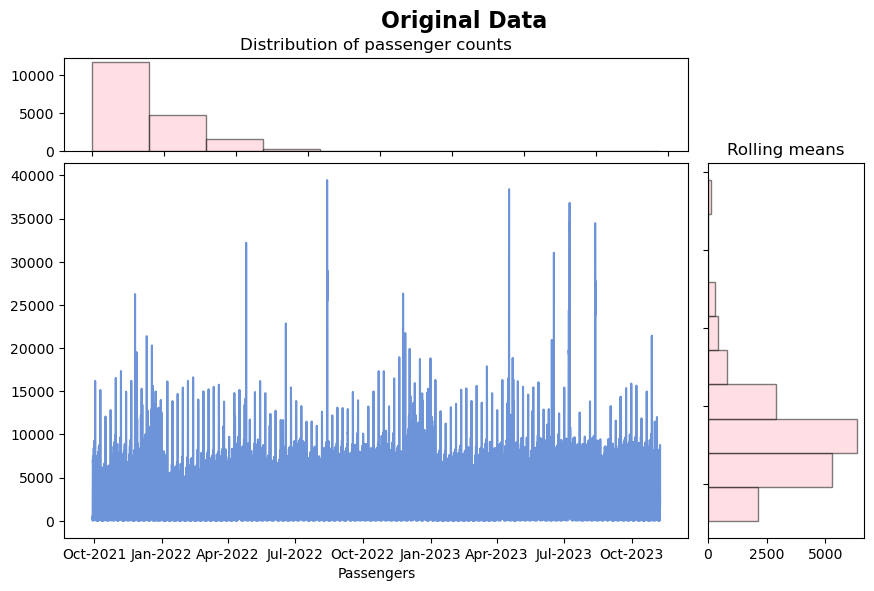

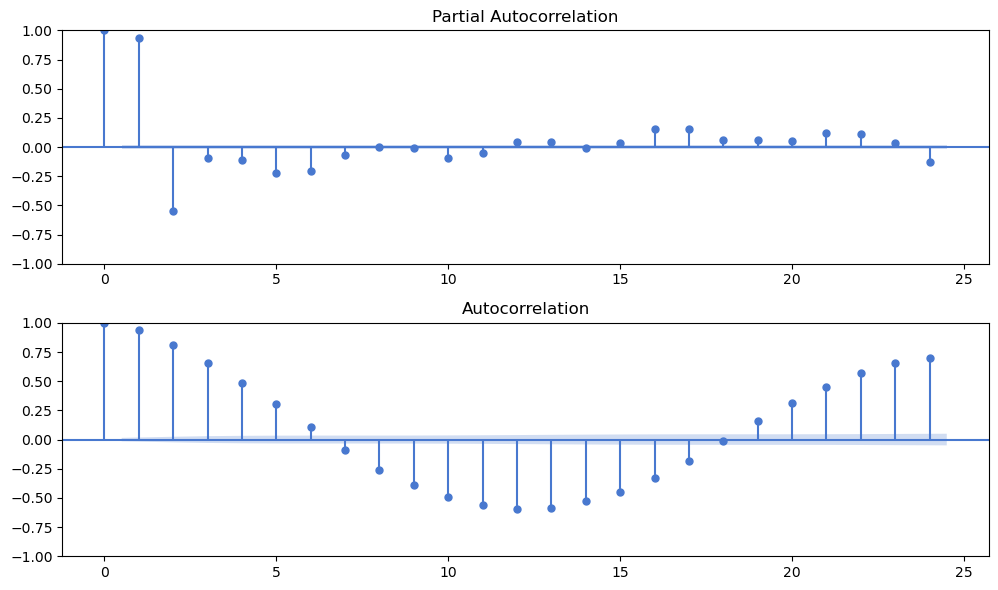

In [122]:
plot_three(passengers.total, "Original Data")

# Log Transformation

Log transformation to stabilize the variance of the series (https://otexts.com/fpp2/stationarity.html)

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Results of the AD Fuller test:
Test Statistic: -18.713
p-value:  0.0000
----------------
Results of KPSS Test:
Test Statistic 0.158
p-value:  0.0404
Lags used:  19
----------------
The means are 7.27, 7.38 and 7.42
The stds are 1.70, 1.66 and 1.65


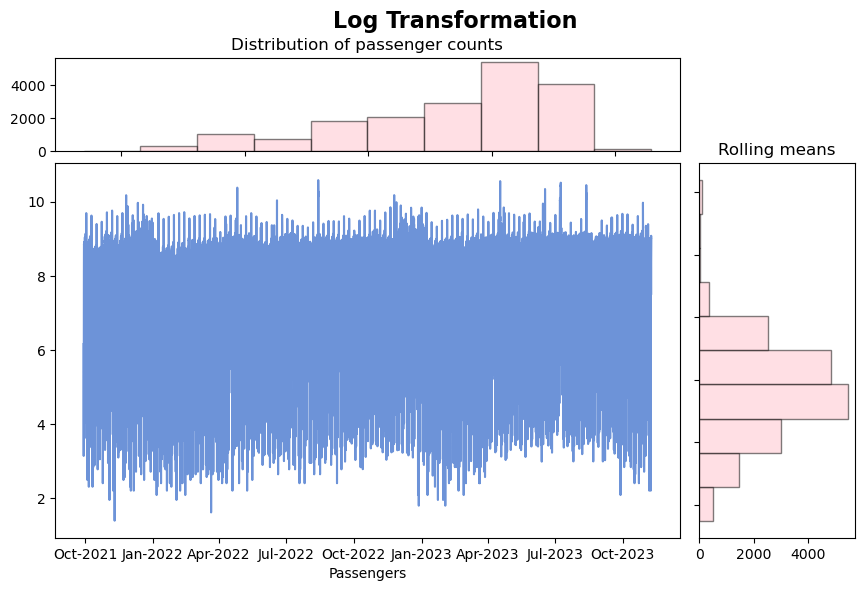

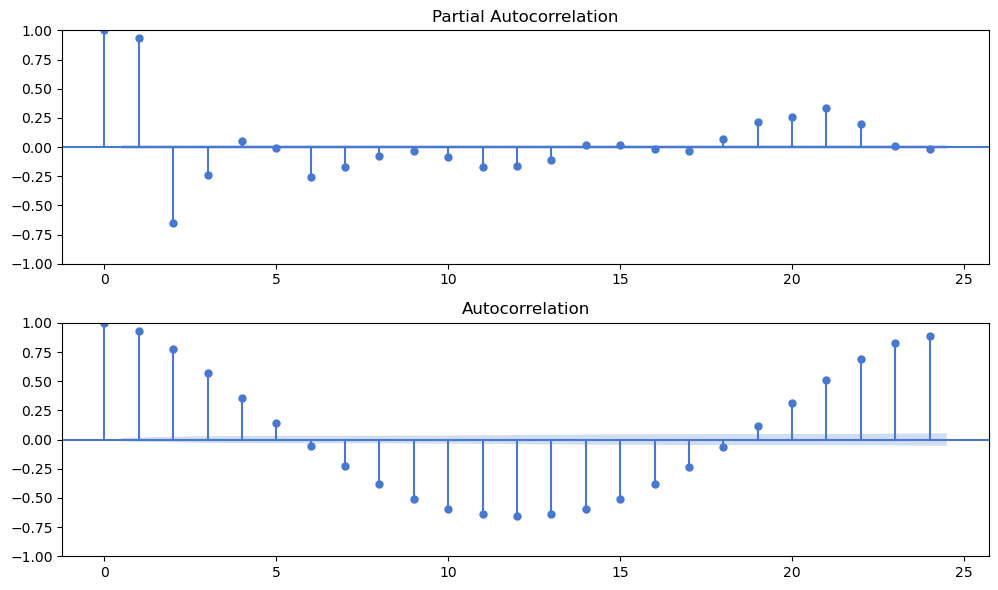

In [123]:
# log transform the dataset to make the distribution 
# of values more linear and better meet the expectations of this statistical test.
transform = np.log(passengers)
plot_three(transform.total, "Log Transformation")

# Eliminate Seasonality through Differencing

Start by removing daily seasonality

Results of the AD Fuller test:
Test Statistic: -30.469
p-value:  0.0000
----------------
Results of KPSS Test:
Test Statistic 0.001
p-value:  0.1000
Lags used:  51
----------------
The means are-0.00, 0.00 and-0.00
The stds are 0.80, 0.79 and 0.81


/tmp/ipykernel_1267/13139041.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(series, regression="ct", nlags="auto")


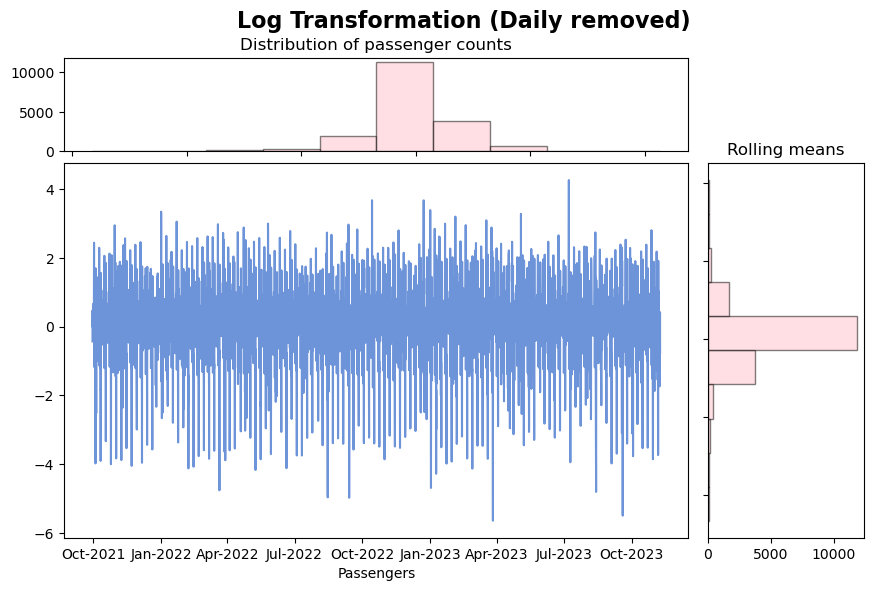

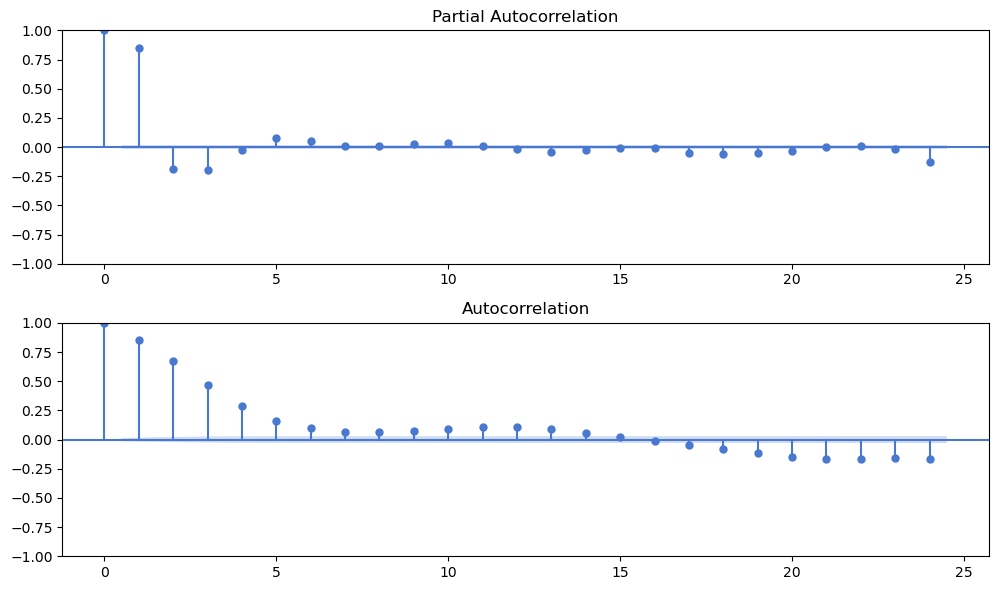

In [124]:
# Eliminate daily seasonality
daily_24 = transform.diff(24).dropna()
plot_three(daily_24.total, "Log Transformation (Daily removed)")

### Remove the weekly seasonality

Results of the AD Fuller test:
Test Statistic: -27.803
p-value:  0.0000
----------------
Results of KPSS Test:
Test Statistic 0.002
p-value:  0.1000
Lags used:  55
----------------
The means are 0.00,-0.00 and-0.00
The stds are 0.58, 0.59 and 0.62


/tmp/ipykernel_1267/13139041.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(series, regression="ct", nlags="auto")


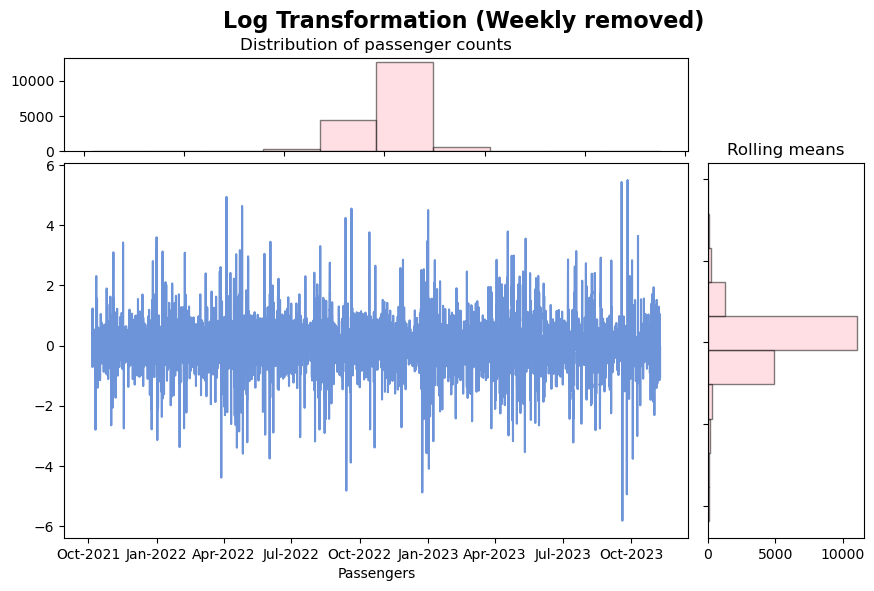

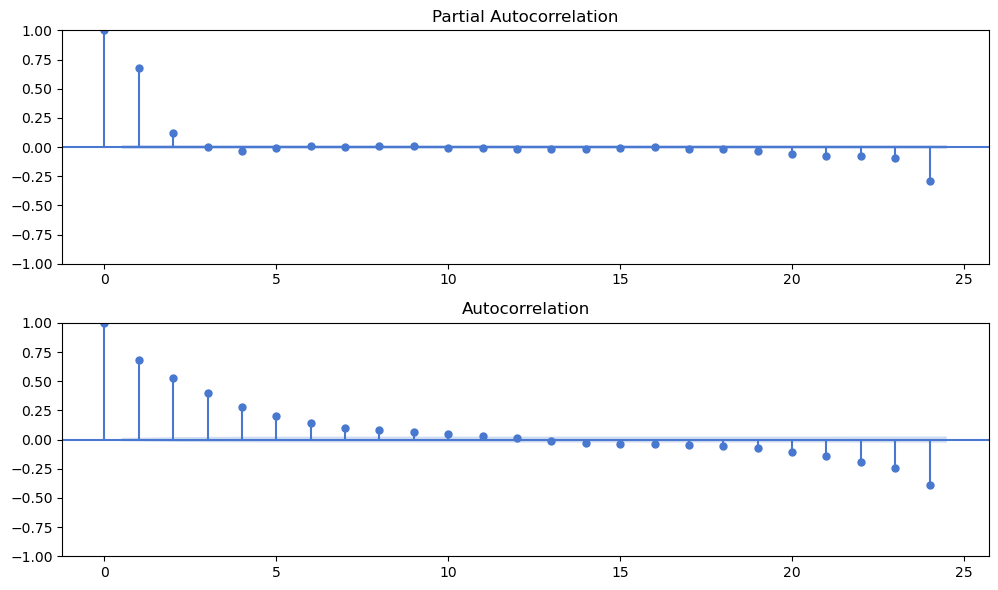

In [125]:
# Remove weekly seasonality
weekly = daily_24.diff(24*7).dropna()
plot_three(weekly.total, "Log Transformation (Weekly removed)")

### Remove the Monthly Seasonality

Results of the AD Fuller test:
Test Statistic: -25.682
p-value:  0.0000
----------------
Results of KPSS Test:
Test Statistic 0.002
p-value:  0.1000
Lags used:  54
----------------
The means are 0.00,-0.00 and-0.00
The stds are 0.78, 0.86 and 0.86


/tmp/ipykernel_1267/13139041.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(series, regression="ct", nlags="auto")


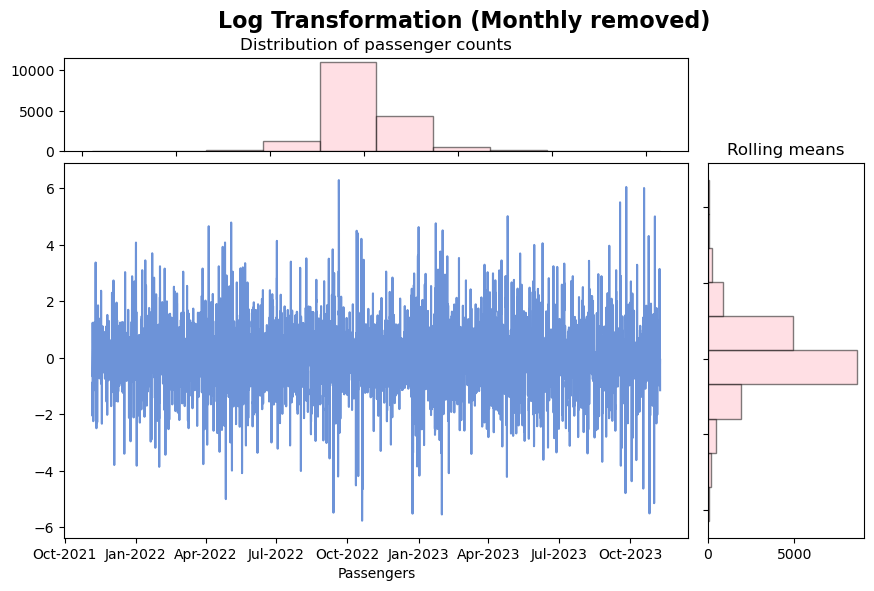

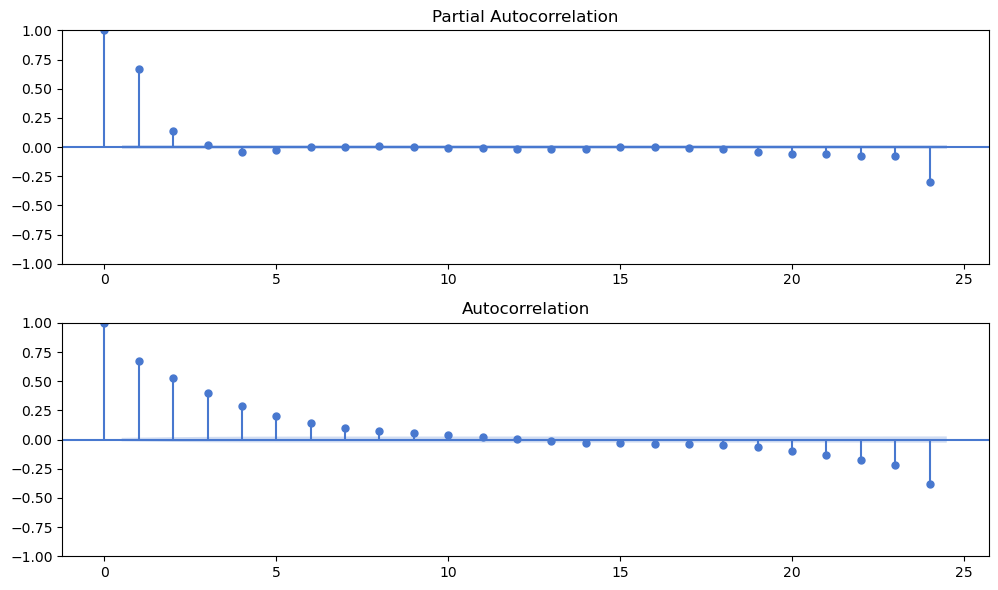

In [126]:
# Remove monthly
monthly = weekly.diff(24*30).dropna()
plot_three(monthly.total, "Log Transformation (Monthly removed)")

### Remove the Yearly Seasonality

Results of the AD Fuller test:
Test Statistic: -17.723
p-value:  0.0000
----------------
Results of KPSS Test:
Test Statistic 0.004
p-value:  0.1000
Lags used:  41
----------------
The means are 0.01, 0.01 and-0.01
The stds are 1.07, 1.20 and 1.23


/tmp/ipykernel_1267/13139041.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(series, regression="ct", nlags="auto")


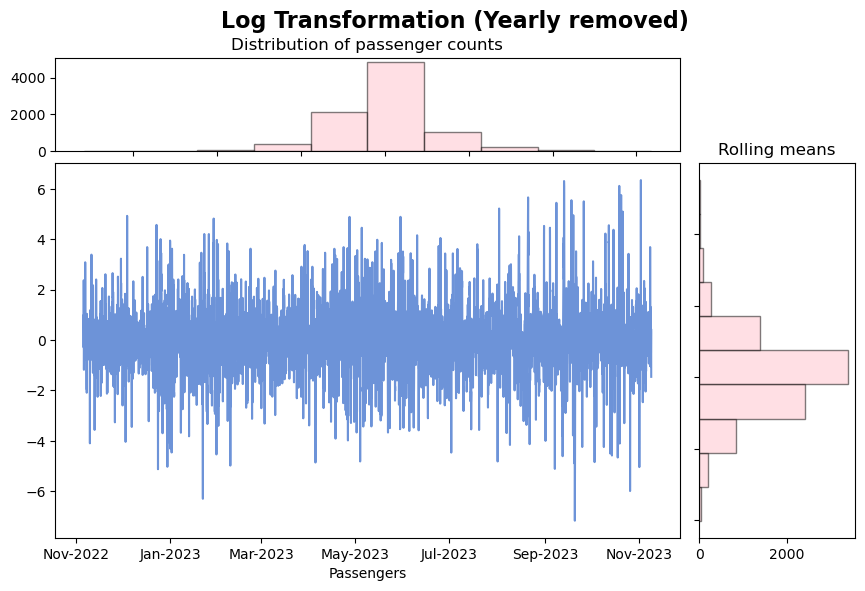

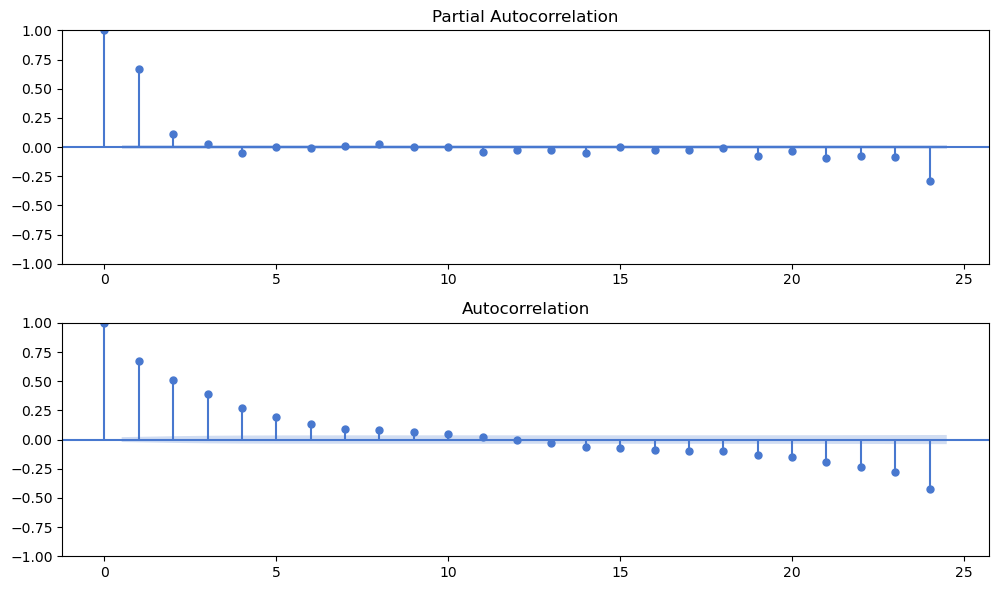

In [127]:
# Remove yearly
yearly = monthly.diff(24*365).dropna()
plot_three(yearly.total, "Log Transformation (Yearly removed)")

### Remove Monthly and Daily only

Results of the AD Fuller test:
Test Statistic: -36.837
p-value:  0.0000
----------------
Results of KPSS Test:
Test Statistic 0.001
p-value:  0.1000
Lags used:  47
----------------
The means are 0.00,-0.00 and 0.00
The stds are 1.26, 1.25 and 1.25


/tmp/ipykernel_1267/13139041.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(series, regression="ct", nlags="auto")


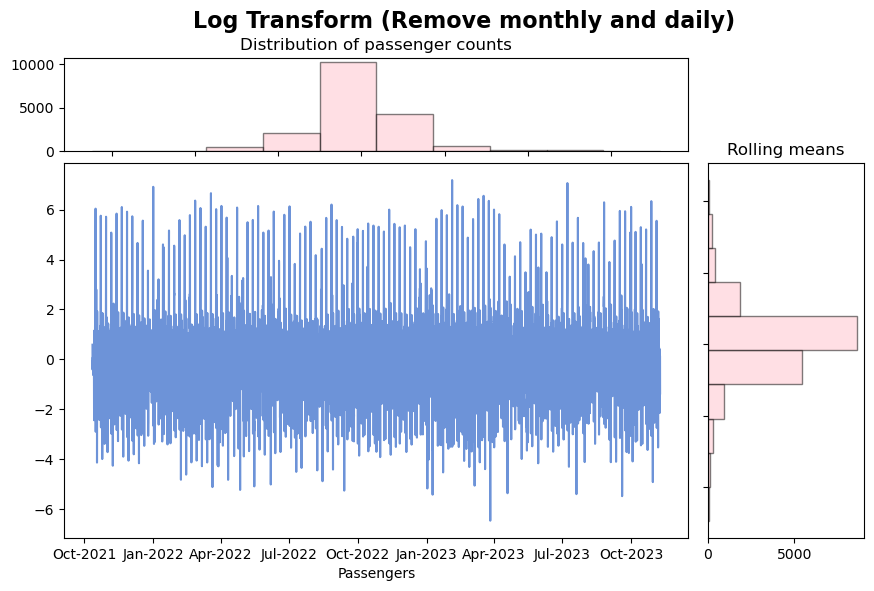

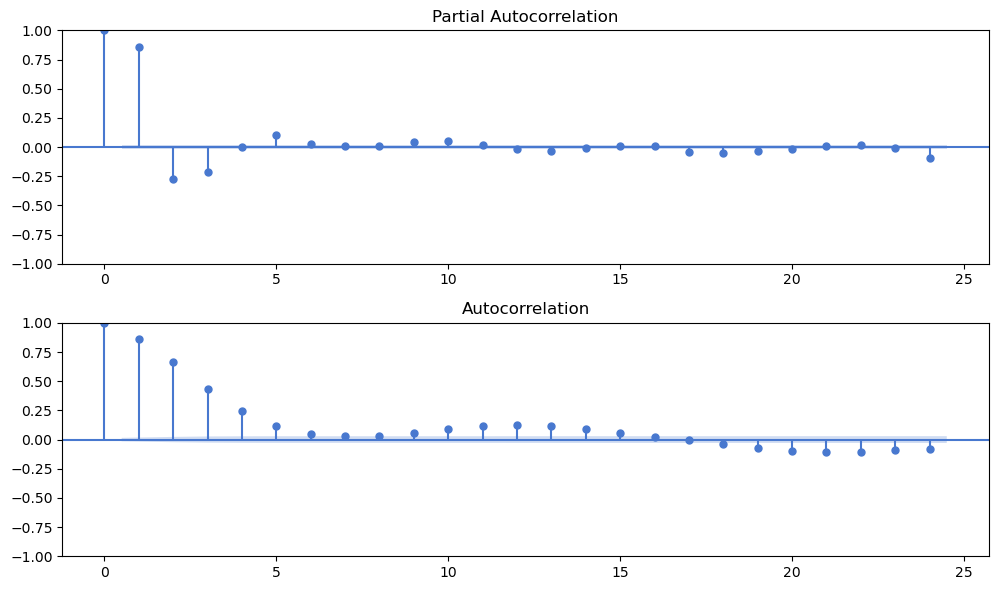

In [128]:
md = transform.diff(24*12).diff(24).dropna()
plot_three(md.total, "Log Transform (Remove monthly and daily)")

### Remove seasonality using Fourier Transformation

In [129]:
# Apply Fourier Transformation
result = seasonal_decompose(transform.total, model='additive', period=24)
detrended_data = transform.total - result.seasonal
detrended_data= detrended_data.diff(24).dropna()

Results of the AD Fuller test:
Test Statistic: -30.359
p-value:  0.0000
----------------
Results of KPSS Test:
Test Statistic 0.001
p-value:  0.1000
Lags used:  51
----------------
The means are-0.00, 0.00 and-0.00
The stds are 0.80, 0.79 and 0.81


/tmp/ipykernel_1267/13139041.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(series, regression="ct", nlags="auto")


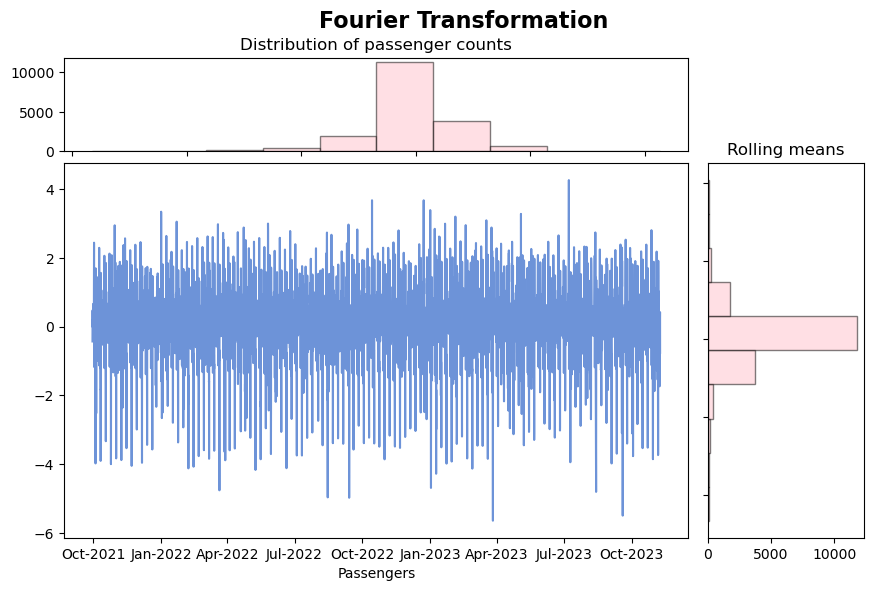

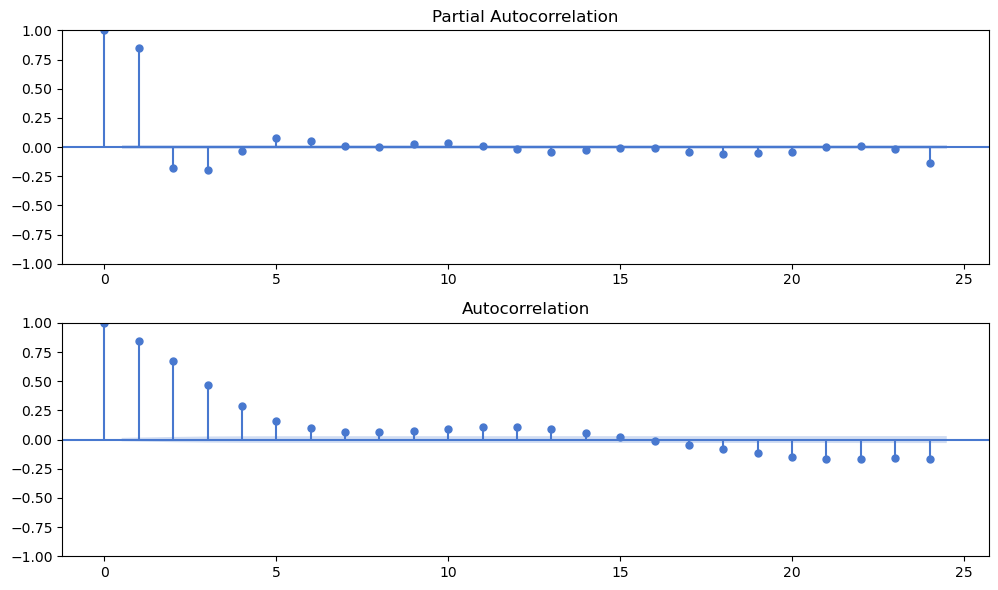

In [130]:
plot_three(detrended_data, "Fourier Transformation")